In [1]:
import progressbar
import pandas as pd
import glob
import matplotlib.pyplot as plt
from math import ceil

import numpy


density = 1.817  #g/cm3
flowrate_cm2s = True

In [2]:
#find the results file
nsi_cvg_file = glob.glob('*.nsi.cvg', recursive=False)
nsi_set_file = glob.glob('*.nsi.set', recursive=False)

if nsi_cvg_file!=[]:
    for filename in nsi_cvg_file:
        if not 'sgs' in filename:            
            nsi_cvg_file = filename
            break
    print(f'Using input from {nsi_cvg_file}')
    
if nsi_set_file!=[]:
    nsi_set_file = nsi_set_file[0]
    print(f'Using input from {nsi_set_file}')    

Using input from fluidda.nsi.cvg
Using input from fluidda-boundary.nsi.set


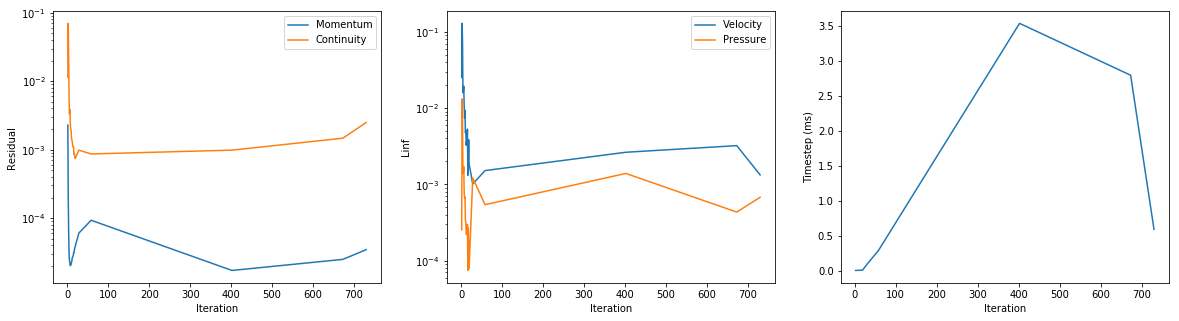

In [5]:
if nsi_cvg_file!=[]:
    nsi_cvg = pd.read_csv(nsi_cvg_file, comment='#', header=None, delim_whitespace=True)
    max_inner_iteration = nsi_cvg[nsi_cvg[0]==1][2].max()
    nsi_cvg = nsi_cvg[nsi_cvg[2]==max_inner_iteration]
    nsi_cvg.sort_values(by=0)

    nsi_cvg['Timestep']=nsi_cvg[3].diff()*1000
    
    
    #plot convergence data
    fig, axes = plt.subplots(1, 3, figsize=(20,5))
    axes[0].plot(nsi_cvg[0], nsi_cvg[15], label='Momentum')
    axes[0].plot(nsi_cvg[0], nsi_cvg[16], label='Continuity')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Residual')
    axes[0].legend()

    axes[1].plot(nsi_cvg[0], nsi_cvg[4], label='Velocity')
    axes[1].plot(nsi_cvg[0], nsi_cvg[5], label='Pressure')
    axes[1].set_yscale('log')
    axes[1].set_ylabel('Linf')
    axes[1].set_xlabel('Iteration')
    axes[1].legend()

    axes[2].plot(nsi_cvg[0], nsi_cvg['Timestep'])
    axes[2].set_ylabel('Timestep (ms)')
    axes[2].set_xlabel('Iteration')



#    plt.show()
    

100% (8320 of 8320) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (8320 of 8320) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


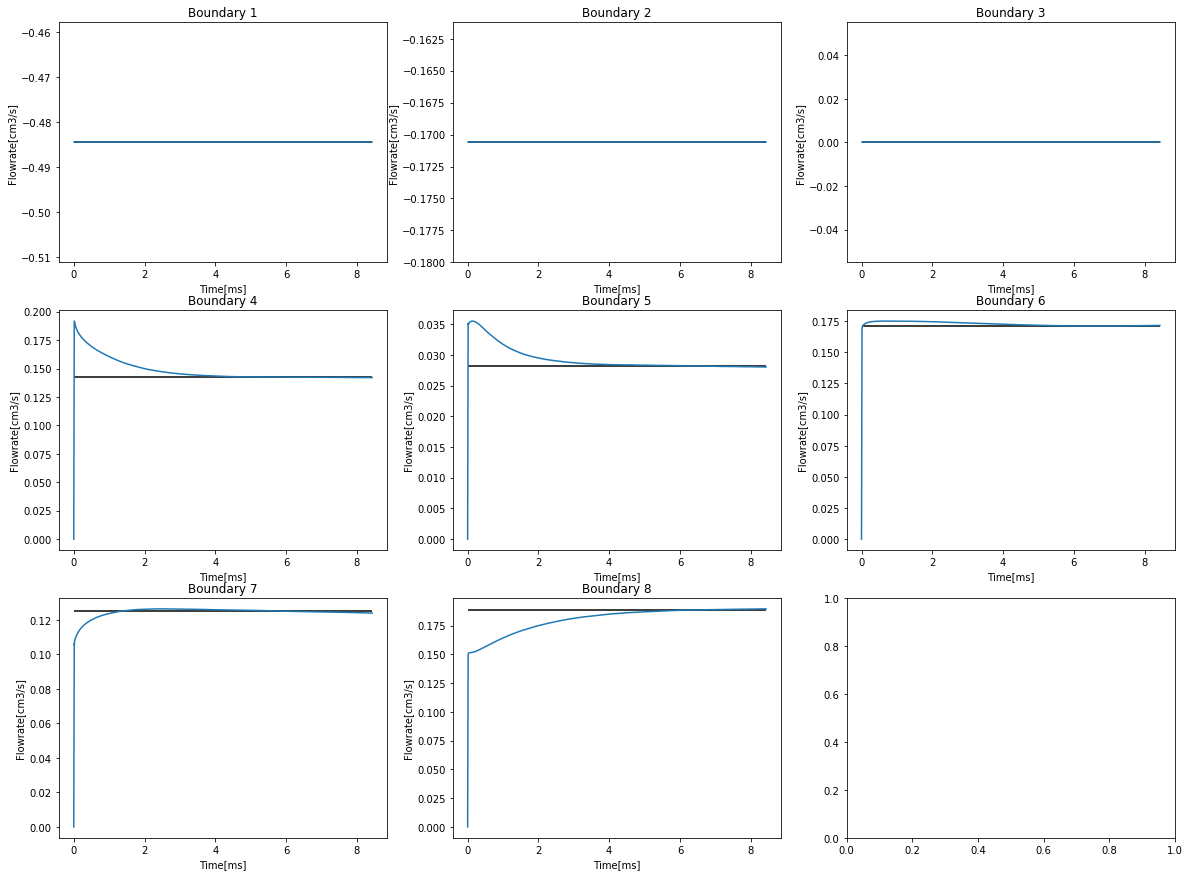

In [20]:
#plot the flowrates
if nsi_set_file!=[]:

    #read header
    numsets = 0
    with open(nsi_set_file, 'r') as f:
        data = f.readlines()    

    for line in data:
        if 'NUMSETS' in line:
            numsets = int(line.split(':')[1])
            break

    #extracts the fow rate -- last column
    initial_time = 11
    step = numsets+2
    i = 0
    offset = 0*step+initial_time
    times = []
    flowrates = {}

    #get the times and the number of time instants
    with progressbar.ProgressBar(max_value=len(data)) as bar:
        while offset<len(data):  
            time = float(data[offset].split(' ')[-1])
            #print(time)
            times = times+[time]
            i=i+1
            bar.update(offset)
            offset = i*step+initial_time



    #get the ids of boundaries and initialize the sotrage       
    offset = 0*step+initial_time
    for j in range(step-2):
        boundary = data[offset+j+1].strip().split(' ')[0]
        flowrates[boundary] = [None] * len(times)


    #fill the flowrates  
    i = 0
    with progressbar.ProgressBar(max_value=len(data)) as bar:
        while offset<len(data):          
            for j in range(step-2):
                boundary = data[offset+j+1].strip().split(' ')[0]    
                flowrate = data[offset+j+1].strip().split(' ')[-1]
                flowrates[boundary][i] = flowrate

            i=i+1
            bar.update(offset)
            offset = i*step+initial_time

    df = pd.DataFrame(flowrates, dtype=float)
    
    if flowrate_cm2s:
        df = df/density
    
    df['Time']=times

    df = df.reindex(sorted(df.columns), axis=1)

    df['Time'] = df['Time']*1000

    tmax = df['Time'].max()
    mask = (df['Time']>=tmax/2) & (df['Time']<=tmax)
    df_middletime = df.loc[mask,:]
    stats = df_middletime.describe();

    m = 3
    n = ceil(df.shape[1]/3)

    fig, axes = plt.subplots(n, m, figsize=(20,5*n), sharex=True)


    i =0
    j =0
    for col in df.columns:
        if col=='Time':
            continue

        axes[j,i].plot(df['Time'],df[col])
        
        if flowrate_cm2s:
            axes[j,i].set_ylabel('Flowrate[cm3/s]')
        else:
            axes[j,i].set_ylabel('Flowrate[g/s]')
            
        axes[j,i].set_xlabel('Time[ms]')
        axes[j,i].hlines(y=stats.loc['mean',col], xmin=0, xmax=tmax)
        axes[j,i].set_title(f'Boundary {col}')
        i=i+1
        if i==m:
            j=j+1
            i=0

    plt.show()